# **02**
# MERGING GEOJSON

In [107]:
from os import listdir
from os.path import isfile, join

import re
from itertools import combinations
from itertools import chain

import pandas as pd
import numpy as np

import geopandas as gpd
import geojson
import rtree

import folium.folium

import seaborn as sns
import matplotlib.pyplot as plt

import folium
from folium import plugins

%matplotlib inline

pd.set_option('display.max_rows', 1000)

In [108]:
TRANSITION_PATH = '../data/transition' # transform this into temp file
CLEAN_PATH = '../data/clean'

NAMES_DICT = {
    
    'cadastralparcel.geojson': 'CAD_PA',
    'otherconstruction.geojson': 'O_CONS',
    'buildingpart.geojson': 'P_BU',
    'building.geojson': 'BU',
    'cadastralzoning.geojson': 'CAD_ZO',
    '28900.geojson': 'MAD'
}

MADRID_EPSG = 25830

### DEFINITIONS OF THIS NOTEBOOK

In [109]:
def changes_to_28900(gdf):
    return gdf.drop(['designator', 'yearOfConstruction'], axis = 1, inplace = True)

In [110]:
def merge_to_main_gdf(main_gdf, merged_gdf):
    """
    input:
    output: 
    """
    cols_to_keep_out = ['yearOfConstruction', 'label', 'geometry']     # this labels dont give any info
    cols_to_select = [col for col in merged_gdf.columns.tolist() if col not in cols_to_keep_out]
    
    if len(merged_gdf['ID'].unique()) == len(merged_gdf['ID'].array):
        return main_gdf.merge(merged_gdf[cols_to_select], on ='ID')

    else:
        aux_gdf = merged_gdf[cols_to_select].groupby(['ID']).max() # max as agg
        aux_gdf.reset_index(inplace = True)

        return main_gdf.merge(aux_gdf[cols_to_select], on = 'ID') # main_gdf.merge(aux_gdf, on ='ID')    

In [112]:
def split_xtr(x):
    if x:
        return x.split('_')[-1]

def height_to_floors(gdf):
    for col in gdf.columns:
        if len(re.findall(r'height\w+', col)) != 0:
            sec_part_name = re.split(r'height', col)[1]

            gdf[col] == gdf.apply(lambda x: x[col] / 3, axis = 1)
            gdf.rename(columns = {col: f'nFloors{sec_part_name}'}, inplace = True)
        
        elif len(re.findall(r'numberOf\w+', col)) != 0:
            sec_part_name = re.split(r'numberOf', col)[1]
            gdf.rename(columns = {col: f'n_{sec_part_name}'}, inplace = True)
            
        else: pass
        
def year_to_halfcentury(year):
    """
    esta función debería estar quizá en el primer pipeline
    """
    
    if 0      < int(year) <= 500:  return '00-05'
    elif 500  < int(year) <= 1400: return '05-14'
    elif 1400 < int(year) <= 1600: return '14-16'
    elif 1600 < int(year) <= 1750: return '18-01'
    elif 1750 < int(year) <= 1800: return '18-02'
    elif 1800 < int(year) <= 1850: return '19-01'
    elif 1850 < int(year) <= 1900: return '19-02'
    elif 1900 < int(year) <= 1950: return '20-01'
    elif 1950 < int(year) <= 2000: return '20-02'
    elif 2000 < int(year) <= 2050: return '21-01'
    else: return 'unknown'

In [111]:
def getPolyCoords(row, geom, coord_type):
    """Returns the coordinates ('x|y') of edges/vertices of a Polygon/others"""

    # Parse the geometries and grab the coordinate
    geometry = row[geom]
    #print(geometry.type)

    if geometry.type=='Polygon':
        if coord_type == 'x':
            # Get the x coordinates of the exterior
            # Interior is more complex: xxx.interiors[0].coords.xy[0]
            return list( geometry.exterior.coords.xy[0] )
        elif coord_type == 'y':
            # Get the y coordinates of the exterior
            return list( geometry.exterior.coords.xy[1] )

    if geometry.type in ['Point', 'LineString']:
        if coord_type == 'x':
            return list( geometry.xy[0] )
        elif coord_type == 'y':
            return list( geometry.xy[1] )

    if geometry.type=='MultiLineString':
        all_xy = []
        for ea in geometry:
            if coord_type == 'x':
                all_xy.append(list( ea.xy[0] ))
            elif coord_type == 'y':
                all_xy.append(list( ea.xy[1] ))
        return all_xy

    if geometry.type=='MultiPolygon':
        all_xy = []
        for ea in geometry:
            if coord_type == 'x':
                all_xy.append(list( ea.exterior.coords.xy[0] ))
            elif coord_type == 'y':
                all_xy.append(list( ea.exterior.coords.xy[1] ))
        return all_xy

    else:
        # Finally, return empty list for unknown geometries
        return []
    
def polygonToPtGeom(gdf):
    """
    from geom (poligons) -- > geom (points)
    """
    df_columns = [col for col in gdf.columns if col != 'geometry']
    
    # get coordinates in separate
    gdf['pX'] = gdf.apply(lambda x: float(x['pos'].split(" ")[0]), axis = 1)
    gdf['pY'] = gdf.apply(lambda x: float(x['pos'].split(" ")[1]), axis = 1)
    
    # get points for polygons
    gdf['polyX'] = gdf.apply(lambda x: getPolyCoords(x, 'geometry', 'x'), axis = 1)
    gdf['polyY'] = gdf.apply(lambda x: getPolyCoords(x, 'geometry', 'y'), axis = 1)
    
    # get points for polygons
    res_gdf = gpd.GeoDataFrame(gdf[df_columns],
                               geometry = gpd.points_from_xy(gdf['pX'], gdf['pY']))
    
    # geometry and polyX, polyY for polygons if needed
    return res_gdf

### LOADING BUILDING, BUILDING PART AND CADASTRAL PARCEL DATASETS

In [113]:
all_raw_geofiles = [f for f in listdir(TRANSITION_PATH) if isfile(join(TRANSITION_PATH, f))]

In [114]:
# LOADING CADASTRAL PARCELS
# This adds area_m2p
cad_pa_gdf = gpd.read_file(f"{TRANSITION_PATH}/{all_raw_geofiles[0]}")
cad_pa_gdf.name = NAMES_DICT[all_raw_geofiles[0]]
assert cad_pa_gdf.name == 'CAD_PA'

# LOADING BUILDING
# This is the main dataset from which the final table is constructed
build_gdf = gpd.read_file(f"{TRANSITION_PATH}/{all_raw_geofiles[4]}")
build_gdf.name = NAMES_DICT[all_raw_geofiles[4]]
assert build_gdf.name == 'BU'

# LOADING BUILDING PARTS
# This adds heights and building units
p_build_gdf = gpd.read_file(f"{TRANSITION_PATH}/{all_raw_geofiles[2]}")
p_build_gdf.name = NAMES_DICT[all_raw_geofiles[2]]
assert p_build_gdf.name == 'P_BU'



# LOADING 28900
# Es un Dataset que muestra los portales de Madrid
# El ID es diferente al resto de DS
# Quizá habría que hacer un sjoin()
# ......... en col specification se especifica en donde se mide el portal
# si en entrada o se coge centroide de parcela
mad_gdf = gpd.read_file(f"{TRANSITION_PATH}/{all_raw_geofiles[5]}")
mad_gdf.name = NAMES_DICT[all_raw_geofiles[5]]
# Not necessary but
changes_to_28900(mad_gdf)

# LOADING CADASTRAL ZONING
# Esta tabla sólo habla de piscinas, aunque se supone que es más genérica
cad_zo_gdf = gpd.read_file(f"{TRANSITION_PATH}/{all_raw_geofiles[1]}")
cad_zo_gdf.name = NAMES_DICT[all_raw_geofiles[1]]

# _____________________

#  FINAL RESULT

In [118]:
# merging to building-geojson
final_gdf = merge_to_main_gdf(main_gdf = merge_to_main_gdf(main_gdf = build_gdf, 
                                                           merged_gdf = p_build_gdf), 
                            merged_gdf = cad_pa_gdf)

# tras los merge no es un geodataframe, luego hay que volverlo a convertir en uno
cols_to_select = [col for col in final_gdf.columns.tolist() 
                              if col not in list(re.findall(r"geometry", col))]
cols_to_select += ['geometry']

final_gdf = gpd.GeoDataFrame( final_gdf[cols_to_select], 
                              geometry = final_gdf['geometry'] )

print(f"{build_gdf.name}, {p_build_gdf.name}, {cad_pa_gdf.name} MERGED"\
       + f"\t\tMemory Usage {np.round(final_gdf.memory_usage().sum()/1000000, 2)} Mb")

if final_gdf.crs != 25830:
    final_gdf.set_crs(epsg = MADRID_EPSG)
else:
    pass

print("All good")

BU, P_BU, CAD_PA MERGED		Memory Usage 13.68 Mb
All good


In [119]:
# aplicando las funciones definidas
final_gdf['currentUse'] = final_gdf['currentUse'].apply(split_xtr) # limpiando currentUse
height_to_floors(final_gdf) # cambiando height --> floors 

# TRANSFORM YEAR   
final_gdf['centuryOfConstr'] = final_gdf.apply(lambda x: year_to_halfcentury(x['yearOfConstruction']), 
                                               axis = 1)
final_gdf.drop(['yearOfConstruction'], axis = 1, inplace = True)

# cambiando polygons por puntos
final_points_gdf = polygonToPtGeom(gdf = final_gdf)

# order of columns
order_cols = ['ID', 'conditionOfConstruction', 'currentUse', 'centuryOfConstr', 'n_BuildingUnits', 
              'n_Dwellings', 'nFloors_AG', 'nFloors_BG', 'ID_part', 'area_m2c', 'area_m2p', 'geometry']

# final GDF 
# In gere take into account that separate gdfs / geojson is the most
# stable solution for same table + multiple geometries out there
# FOR FUTURES --> parquet / feather format or making a PostGIS DDBB
final_points_gdf = final_points_gdf[order_cols].set_index('ID')
final_polygs_gdf = final_gdf[order_cols].set_index('ID')
final_parcel_gdf = gpd.GeoDataFrame(final_points_gdf, 
                                    geometry = cad_pa_gdf.set_index('ID')['geometry'])

assert final_points_gdf.shape == final_polygs_gdf.shape == final_parcel_gdf.shape 
print("All good")

All good


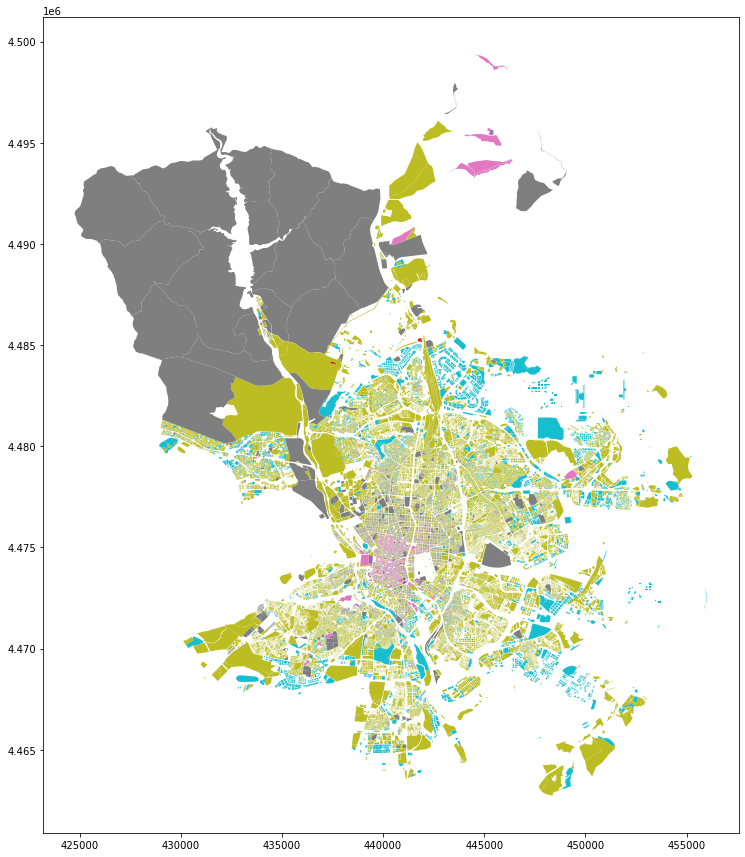

In [95]:
## drawing
col_to_draw = 'centuryOfConstr' # col value corresponds grossfloorarea

final_parcel_gdf[['geometry', col_to_draw]].plot(figsize = (15,15), column = col_to_draw, legend = False)
plt.show()

# _____________________

# SAVING FINAL FILES

In [ ]:
final_polygs_gdf.to_file(f"{CLEAN_PATH}/building_polygs.geojson", driver='GeoJSON')
final_points_gdf.to_file(f"{CLEAN_PATH}/building_points.geojson", driver='GeoJSON')
final_parcel_gdf.to_file(f"{CLEAN_PATH}/building_parcls.geojson", driver='GeoJSON')